In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tensorboardX import SummaryWriter
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
from torch.autograd import Variable

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
print(torch.cuda.is_available())

False


In [3]:
class Gaussian(object):
    def __init__(self, mu, rho):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(0,1)
    
    @property
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))
    
    def sample(self):
        epsilon = self.normal.sample(self.rho.size()).to(DEVICE)
        return self.mu + self.sigma * epsilon
    
    def log_prob(self, input):
        return (-math.log(math.sqrt(2 * math.pi))
                - torch.log(self.sigma)
                - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()

In [4]:
class ScaleMixtureGaussian(object):
    def __init__(self, pi, sigma1, sigma2):
        super().__init__()
        self.pi = pi
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.gaussian1 = torch.distributions.Normal(0,sigma1)
        self.gaussian2 = torch.distributions.Normal(0,sigma2)
    
    def log_prob(self, input):
        prob1 = torch.exp(self.gaussian1.log_prob(input))
        prob2 = torch.exp(self.gaussian2.log_prob(input))
        return (torch.log(self.pi * prob1 + (1-self.pi) * prob2)).sum()

In [5]:
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        # Weight parameters
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5,-4))
        self.weight = Gaussian(self.weight_mu, self.weight_rho)
        # Bias parameters
        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-5,-4))
        self.bias = Gaussian(self.bias_mu, self.bias_rho)
        # Prior distributions
        self.weight_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.bias_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.log_prior = 0
        self.log_variational_posterior = 0

    def forward(self, input, sample=False, calculate_log_probs=False):
        if self.training or sample:
            weight = self.weight.sample()
            bias = self.bias.sample()
        else:
            weight = self.weight.mu
            bias = self.bias.mu
        if self.training or calculate_log_probs:
            self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0

        return F.linear(input, weight, bias)

In [17]:
class BayesianNetwork(nn.Module):
    def __init__(self, inputSize, CLASSES, layers, activations, SAMPLES, BATCH_SIZE, NUM_BATCHES):
        super().__init__()
        self.inputSize = inputSize
        self.activations = activations
        self.CLASSES = CLASSES
        self.SAMPLES = SAMPLES
        self.BATCH_SIZE = BATCH_SIZE
        self.NUM_BATCHES = NUM_BATCHES
        self.DEPTH = 0

        self.layers = nn.ModuleList([])
        if layers.size == 0:
            self.layers.append(BayesianLinear(inputSize, CLASSES))
            self.DEPTH += 1
        else:
            self.layers.append(BayesianLinear(inputSize, layers[0]))
            self.DEPTH += 1
            for i in range(layers.size-1):
                self.layers.append(BayesianLinear(layers[i], layers[i+1]))
                self.DEPTH += 1
            self.layers.append(BayesianLinear(layers[layers.size-1], CLASSES))
            self.DEPTH += 1
            
    def forward(self, x, sample=False):
        x = x.view(-1, self.inputSize)
        layerNumber = 0
        for i in range(self.activations.size):
            if self.activations[i]=='relu':
                x = F.relu(self.layers[layerNumber](x, sample))
            elif self.activations[i]=='softmax':
                x = F.log_softmax(self.layers[layerNumber](x, sample), dim=1)
            else:
                x = self.layers[layerNumber](x, sample)
            layerNumber+= 1
        return x
    
    def log_prior(self):
        value = 0
        for i in range(self.DEPTH):
            value+= self.layers[i].log_prior
        return value
    
    def log_variational_posterior(self):
        value = 0
        for i in range(self.DEPTH):
            value+= self.layers[i].log_variational_posterior
        return value
    
    def sample_elbo(self, input, target):
        samples=self.SAMPLES
        outputs = torch.zeros(samples, self.BATCH_SIZE, self.CLASSES).to(DEVICE)
        log_priors = torch.zeros(samples).to(DEVICE)
        log_variational_posteriors = torch.zeros(samples).to(DEVICE)
        negative_log_likelihood = torch.zeros(samples).to(DEVICE)
        
        for i in range(samples):
            outputs[i] = self.forward(input, sample=True)
            log_priors[i] = self.log_prior()
            log_variational_posteriors[i] = self.log_variational_posterior()
            if CLASSES == 1:
                negative_log_likelihood[i] = (.5 * (target - outputs[i]) ** 2).sum()
            
        log_prior = log_priors.mean()
        log_variational_posterior = log_variational_posteriors.mean()
        if CLASSES > 1:
            negative_log_likelihood = F.nll_loss(outputs.mean(0), target, size_average=False)
        else:
            negative_log_likelihood = negative_log_likelihood.mean()
        loss = (log_variational_posterior - log_prior)/self.NUM_BATCHES + negative_log_likelihood
        return loss, log_prior, log_variational_posterior, negative_log_likelihood

# Regression

In [10]:
def train(net, optimizer, data, target):
    net.train()
    net.zero_grad()
    loss, log_prior, log_variational_posterior, negative_log_likelihood = net.sample_elbo(data, target)
    loss.backward()
    optimizer.step()

In [11]:
TRAIN_EPOCHS = 100
SAMPLES = 1
TEST_SAMPLES = 1
BATCH_SIZE = 20
NUM_BATCHES = 1
TEST_BATCH_SIZE = 50

PI = 0.5
SIGMA_1 = torch.FloatTensor([math.exp(-0)])
SIGMA_2 = torch.FloatTensor([math.exp(-6)])

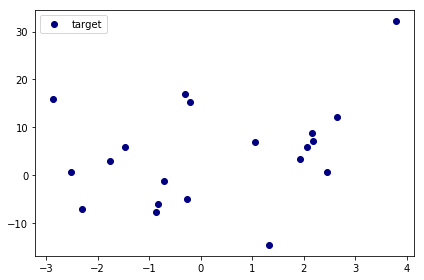

In [21]:
Var = lambda x, dtype=torch.FloatTensor: Variable(torch.from_numpy(x).type(dtype))

x = np.random.uniform(-4, 4, size=BATCH_SIZE).reshape((-1, 1))
noise = np.random.normal(0, 9, size=BATCH_SIZE).reshape((-1, 1))
y = x ** 2 + noise
X = Var(x)
Y = Var(y)

x_test = np.linspace(-5, 5)
y_test = x_test ** 2
X_test = Var(x_test)

plt.scatter(X, Y, c='navy', label='target')
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
net = BayesianNetwork(inputSize = 1,\
                      CLASSES = 1, \
                      layers=np.array([100,100]), \
                      activations = np.array(['relu','relu','none']), \
                      SAMPLES = SAMPLES, \
                      BATCH_SIZE = BATCH_SIZE,\
                      NUM_BATCHES = NUM_BATCHES).to(DEVICE)
optimizer = optim.Adam(net.parameters())
for epoch in range(TRAIN_EPOCHS):
    train(net, optimizer,data=X,target=Y)

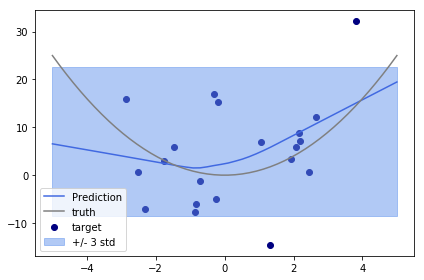

In [25]:
prediction = net.forward(X_test).data.numpy().squeeze(1)
#prediction = [net.forward(X_test).data.numpy().squeeze(1) for _ in range(100)]
#pred = np.array(prediction).T
pred_mean = np.mean(prediction)*np.ones_like(prediction)
pred_std = np.std(prediction)*np.ones_like(prediction)

plt.scatter(x, y, c='navy', label='target')

plt.plot(x_test, prediction, c='royalblue', label='Prediction')
plt.fill_between(x_test, pred_mean - 3 * pred_std, pred_mean + 3 * pred_std,
                     color='cornflowerblue', alpha=.5, label='+/- 3 std')

plt.plot(x_test, y_test, c='grey', label='truth')

plt.legend()
plt.tight_layout()
plt.show()

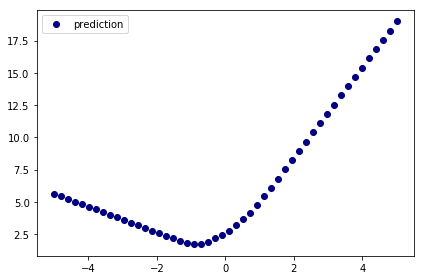

In [23]:
plt.scatter(x_test, prediction, c='navy', label='prediction')
plt.legend()
plt.tight_layout()
plt.show()